## [4주차] 기본과제 - HuggingFace로 두 문장의 논리적 모순 분류하기

MNLI는 두 문장이 주어졌을 때 논리적으로 연결이 되어 있는지, 서로 모순되는지, 아니면 아예 무관한지 분류하는 문제이다.

- **입력**: premise에 해당하는 문장과 hypothesis에 해당하는 문장 두 개가 입력으로 들어옵니다.
- **출력:** 분류 문제로, 두 문장이 들어왔을 때 다음 세 가지를 예측하시면 됩니다.
    - **Entailment:** 두 문장에 논리적 모순이 없습니다.
    - **Neutral:** 두 문장은 논리적으로 관련이 없습니다.
    - **Contradiction:** 두 문장 사이에 논리적 모순이 존재합니다.

In [1]:
%pip install transformers datasets numpy matplotlib evaluate

In [2]:
from datasets import load_dataset

## Dataset 준비

허깅페이스를 통해 mnli 데이터셋을 로드한다.

- train: 모델 학습을 위한 주 데이터셋으로, 다양한 장르의 텍스트로 구성
- validation_matched: 모델 성능 평가를 위한 검증 데이터셋으로, 학습의 데이터와 같은 장르의 텍스트로 구성된다. 모델이 학습한 도메인에서 얼마나 잘 작동하는지 평가한다.
- validation_mismatched: 모델 성능 평가를 위한 검증 데이터셋으로, 학습 데이터와 다른 장르의 텍스트로 구성된다. 모델이 새로운 도메인에서 얼마나 잘 작동하는지 평가한다.
- test_matched: 최종 테스트용 데이터셋으로, 학습 데이터와 같은 장르의 텍스트로 구성된다.
- test_mismatched: 최종 테스트용 데이터셋으로, 학습 데이터와 다른 장르의 텍스트로 구성된다.

학습에 사용한 train 데이터는 392702개, 검증에 사용한 validation_matched 데이터는 9815개이다.

In [3]:
mnli = load_dataset("nyu-mll/glue", "mnli")
mnli

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [4]:
mnli['train'][0]

{'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.',
 'hypothesis': 'Product and geography are what make cream skimming work. ',
 'label': 1,
 'idx': 0}

RoBERTa 토크나이저를 로드하여 데이터셋에 적용한다.

학습에 사용한 데이터셋은 전체의 5%로만 사용한다.

In [5]:
from transformers import AutoTokenizer

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# RoBERTa 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# MNLI 데이터셋을 위한 전처리 함수
def preprocess_function(data):
    return tokenizer(
        data['premise'],
        data['hypothesis'],
        truncation=True,
        max_length=128,
        padding='max_length',
        return_tensors=None
    )

# 데이터셋 토크나이징
tokenized_mnli = mnli['train'].map(preprocess_function, batched=True)
tokenized_validation_matched = mnli['validation_matched'].map(preprocess_function, batched=True)

# 데이터셋의 5%만 사용
train_size = len(tokenized_mnli) // 20    # 약 19,635개
val_size = len(tokenized_validation_matched) // 20   # 약 490개

train_dataset = tokenized_mnli.shuffle(seed=42).select(range(train_size))
validation_dataset = tokenized_validation_matched.shuffle(seed=42).select(range(val_size))

토크나이징한 결과 input_ids와 attention_mask가 추가된 것을 확인할 수 있다.

In [6]:
tokenized_mnli[0].keys()

dict_keys(['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'])

## Model 정의와 학습

모델을 평가할 메트릭을 정의한다.

In [7]:
from transformers import AutoModelForSequenceClassification
import numpy as np
from evaluate import load

# entailment, contradiction, neutral
num_labels = 3

# RoBERTa 모델 로드
model = AutoModelForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=num_labels
)

# 분류기(classifier)를 제외한 모든 레이어 동결
for param in model.roberta.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

accuracy = load("accuracy")

# 평가 메트릭 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    metrics = accuracy.compute(predictions=predictions, references=labels)

    return metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


학습할 때 early stopping을 사용하기 위해 callback을 정의한다.

In [8]:
from transformers import EarlyStoppingCallback

# EarlyStopping 콜백 정의
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,        # 2번의 에포크 동안 성능 향상이 없으면 중단
    early_stopping_threshold=0.0,     # 성능 향상으로 간주할 최소 차이값
)

학습 과정을 시각화하기 위한 callback을 정의한다.

In [9]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt
from IPython.display import clear_output

class VisualizationCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_accuracies = []
        self.last_eval_results = None
        self.learning_rate = None
        self.batch_size = None

    def on_train_begin(self, args, state, control, **kwargs):
        # 학습 시작시 learning rate와 batch size 저장
        self.learning_rate = args.learning_rate
        self.batch_size = args.per_device_train_batch_size

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # 데이터만 저장하고 시각화는 하지 않음
        if state.epoch is not None:
            # validation accuracy 저장
            self.eval_accuracies.append(metrics.get('eval_accuracy', 0))
            self.last_eval_results = metrics

            # train loss 저장
            if len(state.log_history) > 0:
                for entry in reversed(state.log_history):
                    if 'loss' in entry and 'epoch' in entry and entry['epoch'] == state.epoch:
                        self.train_losses.append(entry['loss'])
                        break

    def plot_progress(self):
        print(f"\n{'='*50}")
        print(f"실험 설정: learning_rate={self.learning_rate}, batch_size={self.batch_size}")
        print(f"{'='*50}")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss 그래프
        ax1.plot(self.train_losses, label=f'LR={self.learning_rate}, BS={self.batch_size}', marker='o')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Accuracy 그래프
        ax2.plot(self.eval_accuracies, label=f'LR={self.learning_rate}, BS={self.batch_size}', marker='o')
        ax2.set_title(' Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

        print(f"\n=== 최종 성능 지표 ===")
        print(f"최종 학습 손실: {self.train_losses[-1]:.4f}")
        print(f"최종 검증 정확도: {self.eval_accuracies[-1]:.4f}")

        if self.last_eval_results:
          print(f"\n=== 추가 평가 지표 ===")
          for key, value in self.last_eval_results.items():
              if key not in ['eval_accuracy']:  # 이미 출력한 정확도는 제외
                  if isinstance(value, float):
                      print(f"{key}: {value:.4f}")
                  else:
                      print(f"{key}: {value}")
        print(f"\n{'='*50}\n")

# Trainer 설정 업데이트
visualization_callback = VisualizationCallback()

하이퍼파라미터에 따른 변화를 비교하기 위해 학습 함수를 정의한다.

In [11]:
from transformers import TrainingArguments, Trainer

import torch

# GPU 사용 가능 여부 확인 (CUDA와 MPS 모두 체크)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

def model_experiments(learning_rate, batch_size):
    # 실험 결과를 저장할 딕셔너리
    experiment_name = f"lr: {learning_rate} batch_size: {batch_size}"

    # TrainingArguments 설정
    training_args = TrainingArguments(
        output_dir=f"./results_{experiment_name}",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=50,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,           # 저장할 체크포인트 수 제한
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        greater_is_better=True,
        logging_strategy="epoch",
        logging_dir=f"./logs_{experiment_name}",
        report_to="none",
        # Device 관련 설정
        dataloader_num_workers=2,         # 데이터 로더 병렬 처리
        fp16=device.type=="cuda",         # CUDA에서만 fp16 사용
    )

    # 모델 초기화
    model = AutoModelForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels=num_labels
    )

    # RoBERTa 동결
    for param in model.roberta.parameters():
        param.requires_grad = False

    model = model.to(device)

    # 시각화 콜백 초기화
    visualization_callback = VisualizationCallback()

    # Trainer 설정
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=validation_dataset,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback, visualization_callback]
    )

    # 학습
    trainer.train()

    # 평가
    eval_results = trainer.evaluate()

    # 시각화
    visualization_callback.plot_progress()

    # 결과 저장
    results = {
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'validation_results': eval_results,
        'train_losses': visualization_callback.train_losses,
        'eval_accuracies': visualization_callback.eval_accuracies,
    }

    return results



학습율과 batch size를 변경하며 학습을 진행한다.


실험 설정: learning_rate=0.001, batch_size=32


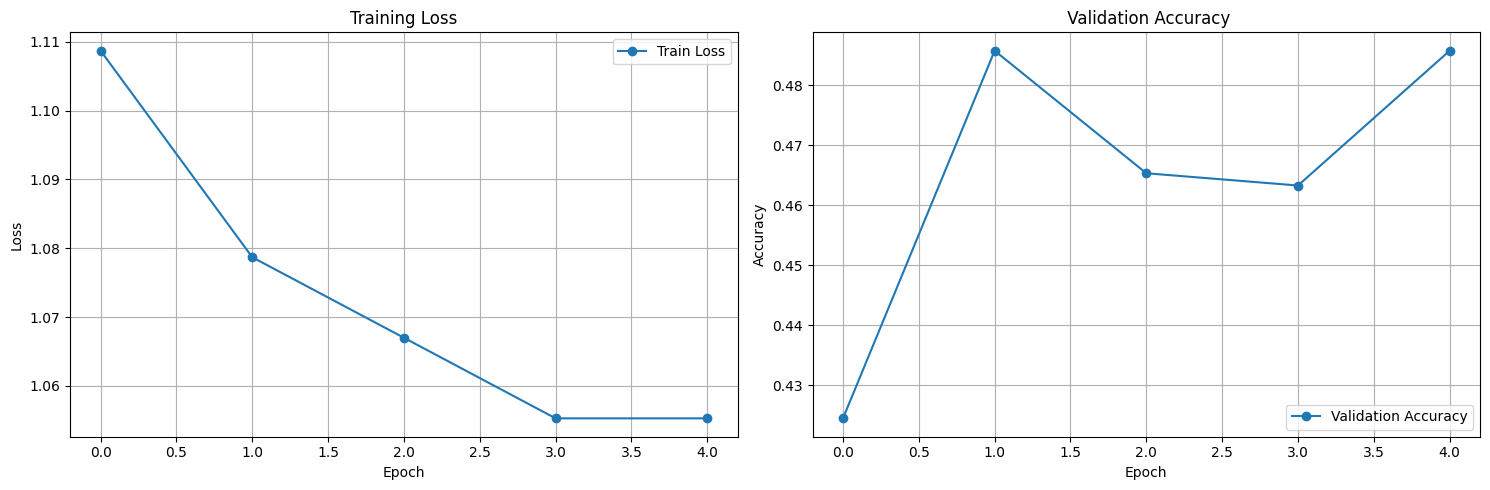


=== 최종 성능 지표 ===
최종 학습 손실: 1.0553
최종 검증 정확도: 0.4857

=== 추가 평가 지표 ===
eval_loss: 1.0293
eval_runtime: 1.2882
eval_samples_per_second: 380.3790
eval_steps_per_second: 12.4210
epoch: 4.0000


In [12]:
# 실험 실행
results = []
learning_rates = [2e-5, 5e-5, 1e-3]
batch_size_list = [16, 32]

for lr in learning_rates:
    for batch_size in batch_size_list:
        print(f"\n실험 시작: learning_rate={lr}, batch_size={batch_size}")
        result = model_experiments(lr, batch_size)
        results.append(result)  # 결과 저장